# **Reinforcement Learning: An Introduction** - Chapter 5
Thomas Hopkins

## **Exercise 5.1**
The value function jumps up for the last two rows in the rear because the player's policy is to stick at a sum of 20 or 21. It is consistently lower otherwise because it often hits and busts when the sum is less than 20. It drops off for the entire last row on the left because it is more difficult to win when the dealer is showing an Ace. This is because the Ace counts as 1 or 11 and it only needs a 10 to get the maximum score of 21. The probability of getting a 10 is higher than any other number in the deck. The frontmost values are higher with a useable Ace since even if you hit and exceed 21 with an Ace counting as 11, then you can fall back on it as counting as 1 and get another hit for free.

## **Exercise 5.2**
The backup diagram for Monte Carlo estimation of $Q^{\pi}$ is the same as that of $V^{\pi}$ except that the top node of the diagram is black (representing a state-action pair).

## **Exercise 5.3**
Let $p_i(s, a)$ and $p_i'(s, a)$ denote the probabilites of a complete sequence happening given policies $\pi$ and $\pi'$ and starting with state $s$ and action $a$.
$$Q(s, a) = \frac{\sum_{i=1}^{n_{sa}} \frac{p_i(s,a)}{p_i'(s, a)} R_i(s, a)}{\sum_{i=1}^{n_{sa}} \frac{p_i(s, a)}{p_i'(s, a)}}$$
where
$$\frac{p_i(s,a)}{p_i'(s, a)} = \prod_{k=t+1}^{T_i(s) - 1} \frac{\pi(s_k, a_k)}{\pi'(s_k, a_k)}$$

## **Exercise 5.4**
We start by implementing the environment. One issue that arose (which I never fixed) was handling invalid actions. Right now, if an invalid action is performed it gets thrown out and a random valid action is chosen instead. It would be better to instead incorporate the velocity in the state space so that a more fine-grained value function can be learned. This would more likely produce optimal behavior.

In [1]:
using DelimitedFiles
using Random
using StatsBase
using Plots
gr()

ACTIONS = [[-1, -1], [-1, 0], [-1, 1],
           [0, -1], [0, 0], [0, 1],
           [1, -1], [1, 0], [1, 1]]

function valid_states(grid::Array{Int})
    return findall((grid .== 1) .| (grid .== 3))
end

function valid_next(grid::Array{Int}, position::CartesianIndex{2})
    states = valid_states(grid)
    up = CartesianIndex{2}(position[1] - 1, position[2])
    right = CartesianIndex{2}(position[1], position[2] + 1)
    if right in states || right in goal_states(grid)
        return right
    end
    return up
end

function start_states(grid::Array{Int})
    return findall(grid .== 3)
end

function goal_states(grid::Array{Int})
    return findall(grid .== 2)
end

function out_of_bounds(grid::Array{Int})
    return findall(grid .== 0)
end

function nonterminal_states(grid::Array{Int})
    return findall(grid .== 1)
end

function valid_actions(velocity::Vector{Int})
    return [a for a in ACTIONS if (0 <= velocity[1] + a[1] <= 5) &&
                (0 <= velocity[2] + a[2] <= 5)]
end

function perform_action(velocity::Vector{Int}, action::Vector{Int})
    tmp = copy(velocity)
    tmp .+= action
    if (0 <= tmp[1] <= 5) && (0 <= tmp[2] <= 5)
        velocity = tmp
        return true, velocity
    end
    return false, velocity
end

function step(grid::Array{Int}, position::CartesianIndex{2},
        velocity::Vector{Int})
    new_position = [position[1] - velocity[1], position[2] + velocity[2]]
    # add randomness for increased difficulty
    if rand() < 0.5
        if rand() < 0.5
            new_position[1] -= 1
        else
            new_position[2] += 1
        end
    end
    new_position = CartesianIndex{2}(new_position...)
    reward = -1.0
    terminated = false
    if new_position[1] <= 0 || new_position[1] > size(grid, 1) ||
        new_position[2] <= 0 || new_position[2] > size(grid, 2) ||
        new_position in out_of_bounds(grid)
        new_position = valid_next(grid, position)
        reward = -5.0
    end
    if grid[new_position] == 2
        # GOAL STATE
        reward = 0.0
        terminated = true
    end
    return new_position, reward, terminated
end;

Now we can write the learning algorithm: On-policy Monte Carlo control

In [2]:
function on_policy_monte_carlo_control(grid::Array{Int}; 
        num_episodes = 1000,
        discount = 1.0,
        epsilon = 0.01)
    # Initialization
    states = valid_states(grid)
    policy = Dict(s => [ 1 / size(ACTIONS, 1)
            for a in ACTIONS ] for s in states)
    q_values = Dict(s => Dict(a => 0.0
            for a in ACTIONS) for s in states)
    returns = Dict(s => Dict(a => []
            for a in ACTIONS) for s in states)
    
    # Simulation & learning
    for i = 1:num_episodes
        # Generate an episode using policy
        state = rand(start_states(grid))
        episode = []
        terminated = false
        velocity = [0, 0]
        while !terminated
            # keep sampling actions until a valid one is chosen
            a = sample(ACTIONS, Weights(policy[state]))
            success, velocity = perform_action(velocity, a)
            if !success
                a = rand(valid_actions(velocity))
            end
            success, velocity = perform_action(velocity, a)
            push!(episode, [state, a, 0.0])
            state, reward, terminated = step(grid, state, velocity)
            episode[end][3] = reward
        end
        for (t, (s, a, r)) in enumerate(episode)
            if t == size(episode, 1)
                R = episode[end][3]
            else
                R = sum([ discount^k * episode[t + k + 1][3]
                        for k = 0:size(episode, 1) - 1 - t])
            end
            append!(returns[s][a], R)
            q_values[s][a] = mean(returns[s][a])
        end
        for (t, (s, _, _)) in enumerate(episode)
            best_a = argmax([ q_values[s][a] for a in ACTIONS ])
            for (i, a) in enumerate(ACTIONS)
                if a == best_a
                    policy[s][i] = 1 - epsilon + epsilon / size(ACTIONS, 1)
                else
                    policy[s][i] = epsilon / size(ACTIONS, 1)
                end
            end
        end
    end
    return policy
end

function eval!(grid::Array{Int}, policy)
    tmp = deepcopy(grid)
    state = rand(start_states(grid))
    tmp[state] = 9
    terminated = false
    velocity = [0, 0]
    while !terminated
        a = ACTIONS[argmax(policy[state])]
        success, velocity = perform_action(velocity, a)
        if !success
            a = rand(valid_actions(velocity))
        end
        success, velocity = perform_action(velocity, a)
        state, reward, terminated = step(grid, state, velocity)
        tmp[state] = 9
    end
    
    heatmap(rotl90(transpose(tmp)))
end;

Let's load in the first track from `RaceTrack1.txt` and run the algorithm!

In [3]:
Random.seed!(32)
track1 = readdlm("RaceTrack1.txt", ' ', Int, '\n')
policy = on_policy_monte_carlo_control(track1; num_episodes=10000);

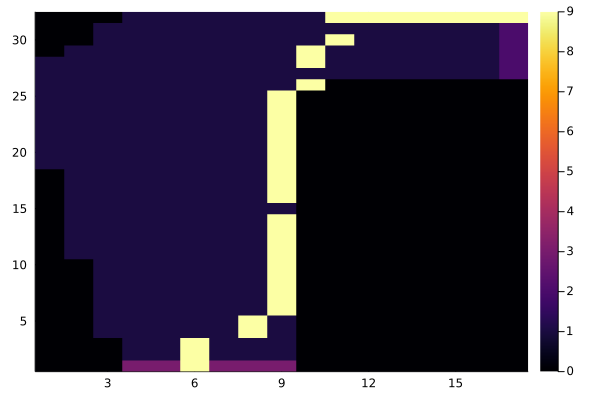

In [4]:
eval!(track1, policy)

Now for the second track: `RaceTrack2.txt`

In [5]:
Random.seed!(32)
track2 = readdlm("RaceTrack2.txt", ' ', Int, '\n')
policy = on_policy_monte_carlo_control(track2; num_episodes=10000);

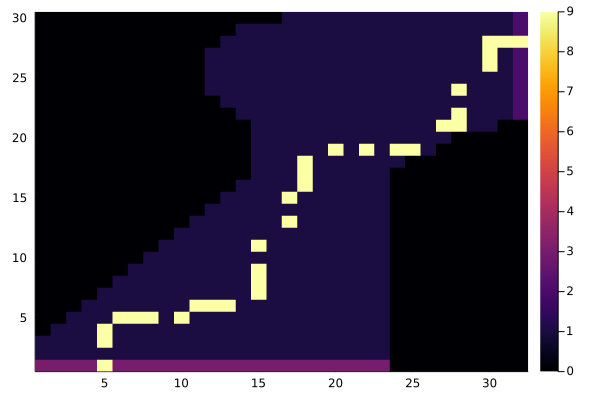

In [6]:
eval!(track2, policy)

## **Exercise 5.5**
Make the following changes and preserve the ordering of the algorithm.
$$Returns(s) \leftarrow an \; empty \; list, \forall s \in \mathscr S \Rightarrow Counts(s) \leftarrow 0, \forall s \in \mathscr S$$
$$Append \; R \; to \; Returns(s) \Rightarrow Counts(s) \leftarrow Counts(s) + 1$$
$$V(s) \leftarrow average(Returns(s)) \Rightarrow V(s) \leftarrow V(s) + \frac{1}{Counts(s)} [R - V(s)]$$

## **Exercise 5.6**
$$V_{n+1} = \frac{\sum_{k=1}^{n+1} w_k R_k}{\sum_{k=1}^{n+1} w_k}$$
$$ = \frac{w_{n+1}R_{n+1} + \sum_{k=1}^n w_k R_k}{W_{n+1}}$$
$$ = \frac{w_{n+1}R_{n+1} + W_nV_n}{ W_{n+1}}$$
$$ = \frac{w_{n+1}R_{n+1} + (W_{n+1} - w_{n+1})V_n }{W_{n+1}}$$
$$ = \frac{w_{n+1}R_{n+1} + W_{n+1}V_n - w_{n+1}V_n}{W_{n+1}}$$
$$ = V_n + \frac{w_{n+1}R_{n+1} - w_{n+1}V_n}{W_{n+1}}$$
$$ = V_n + \frac{w_{n+1}}{W_{n+1}}[R_{n+1} - V_n]$$


## **Exercise 5.7**
Make the following changes and preserve the ordering of the algorithm.
$$N(s, a) \leftarrow 0 \Rightarrow Delete \; Line$$
$$D(s, a) \leftarrow 0 \Rightarrow W(s, a) \leftarrow 0$$
$$N(s, a) \leftarrow N(s, a) + wR_t \Rightarrow Delete \; Line$$
$$D(s, a) \leftarrow D(s, a) + w \Rightarrow W(s, a) \leftarrow W(s, a) + w$$
$$Q(s, a) \leftarrow Q(s, a) + \frac{w}{W(s, a)}[R_t - Q(s, a)]$$